>> Judy Nabil 7575

>> Amr Abdelaziz 7447

>> Ahmed Hany 7387

## Assignment 1

## Husky and Wolf Classification

Import needed libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import hashlib
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
import argparse

Global variables

In [17]:
# Parameters
IMG_SIZE = (128, 128)  # resize all images to 128x128
BATCH_SIZE = 8
EPOCHS = 10
N_SPLITS = 5  # number of folds for cross-validation

# Data Loading

Function that load the images of the dataset 

In [3]:
def load_images(data_dir):
    """
    Loads images and labels from the given directory. Assumes folder structure:
    data_dir/class_name/*.jpg (or other image formats).
    Returns:
        images: list of PIL Images
        labels: list of corresponding labels (string)
    """
    images, labels = [], []
    # Loop over each class folder
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if not os.path.isdir(label_path):
            continue
        for image_file in os.listdir(label_path):
            try:
                img_path = os.path.join(label_path, image_file)
                img = Image.open(img_path).convert("RGB")
                images.append(img)
                labels.append(label.lower())
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return images, labels

Function to visualize some samples of dataset 

In [4]:
def visualize_samples(images, labels, class_name, samples=4):
    """
    Plots 'samples' number of images for the specified class.
    """
    class_images = [img for img, lbl in zip(images, labels) if lbl == class_name.lower()]
    plt.figure(figsize=(8,8))
    for i in range(min(samples, len(class_images))):
        plt.subplot(2,2,i+1)
        plt.imshow(class_images[i])
        plt.title(class_name.capitalize())
        plt.axis("off")
    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.show()

Load images 

Print count of them

In [5]:
# Load training data
train_dir = os.path.join("data", "test_noback")
images, labels = load_images(train_dir)
print(f"Total images loaded: {len(images)}")

Total images loaded: 10


Call function visualize and plot 4 images for each class

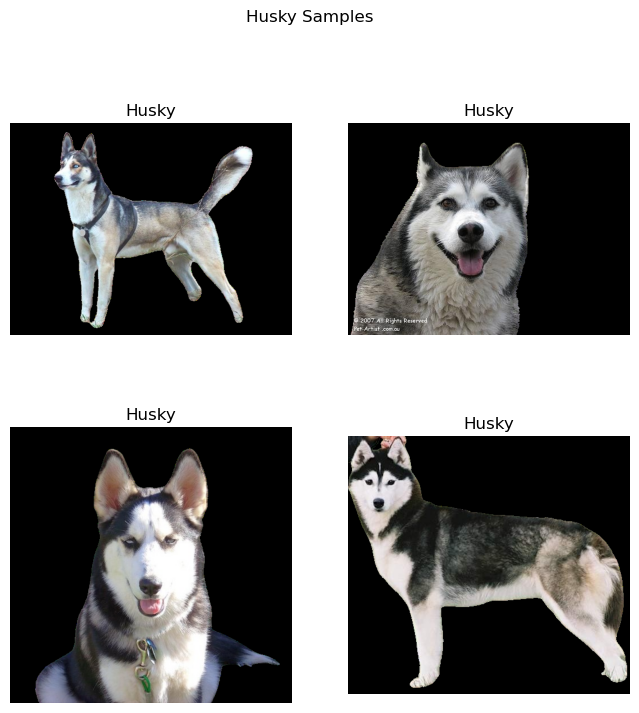

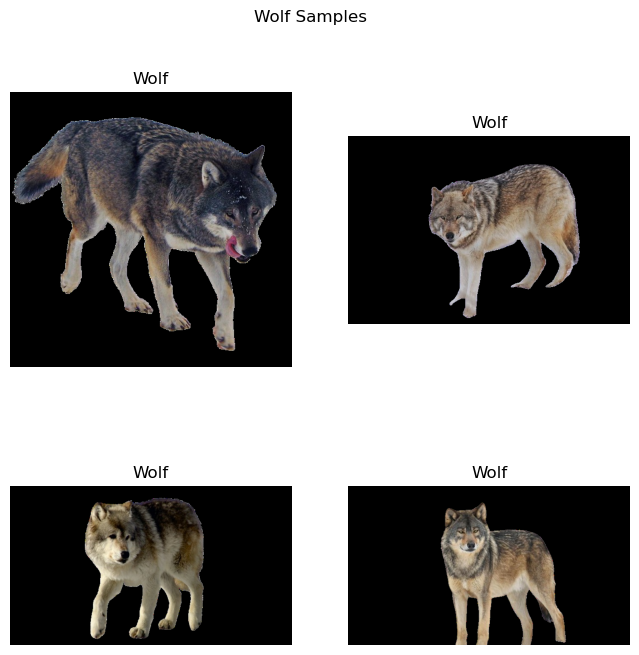

In [6]:
# Visualize 4 husky images
visualize_samples(images, labels, "husky", samples=4)
# Visualize 4 wolf images
visualize_samples(images, labels, "wolf", samples=4)

# Data Preprocessing

    Function to remove duplicate images in dataset

In [7]:
def remove_duplicates(images, labels):
    """
    Computes a hash for each image and removes duplicates.
    Returns unique images and labels.
    """
    seen_hashes = {}
    unique_images, unique_labels = [], []
    for img, lbl in zip(images, labels):
        # Resize image for hash consistency (if needed) and get bytes
        img_bytes = img.tobytes()
        img_hash = hashlib.md5(img_bytes).hexdigest()
        if img_hash not in seen_hashes:
            seen_hashes[img_hash] = True
            unique_images.append(img)
            unique_labels.append(lbl)
    return unique_images, unique_labels

images_clean, labels_clean = remove_duplicates(images, labels)
print(f"Images before cleaning: {len(images)}; after cleaning: {len(images_clean)}")


Images before cleaning: 10; after cleaning: 10


    Function that make:
        1- Image Resize
        2- Normalization

In [8]:
def preprocess_images(images):
    """
    Resize images to IMG_SIZE and convert to numpy arrays scaled in [0,1].
    """
    processed = []
    for img in images:
        img_resized = img.resize(IMG_SIZE)
        img_array = np.array(img_resized) / 255.0  # normalize
        processed.append(img_array)
    return np.array(processed)

X = preprocess_images(images_clean)
# Encode labels: assume two classes, "husky" and "wolf" mapped to 0 and 1.
label_mapping = {"husky": 0, "wolf": 1}
y = np.array([label_mapping[lbl] for lbl in labels_clean])
print("Shape of data:", X.shape, "Labels shape:", y.shape)

Shape of data: (10, 128, 128, 3) Labels shape: (10,)


    Data Augmentation

In [9]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Creating the classifier

Build the neural network model using:
- Multilayer CNN model 
    - 3x3 filter
    - activation function 'relu' except in last layer 'sigmoid'
- Maxpooling to decrease the dimentionality of the image
- Flatten
- Dense layer
- Dropout

In [10]:
def build_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Define some parameters for Hyperparameter tuning

In [ ]:
# Candidate hyperparameters
learning_rates = [ 0.005, 0.001, 0.0005, 0.0001]
dropout_rates  = [0.5, 0.4, 0.3, 0.2]
# batch_sizes    = [8, 16, 32, 64]
# conv_filters   = [32, 64, 128, 256]

# Data Splitting using k-fold

In [18]:
import itertools
# Set up k-fold cross validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

results = []
best_val_acc = 0.0
best_params = {}

# Loop over all hyperparameter combinations
for lr, dr in itertools.product(learning_rates, dropout_rates):
    print(f"\nTrying combination: learning_rate={lr}, dropout_rate={dr}, batch_size={BATCH_SIZE}")
    fold_accuracies = []
    
    # Iterate through each fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        # print(f"\n--- Fold {fold} ---")
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Build a new model for the current fold and hyperparameter combination
        model = build_model(learning_rate=lr, dropout_rate=dr)
        
        # Create data generator for the current batch size (datagen should be pre-defined)
        train_gen = datagen.flow(X_train_fold, y_train_fold, batch_size=BATCH_SIZE)
        
        # Train the model with verbose=1 so each epoch's output is printed
        history = model.fit(train_gen,
                            steps_per_epoch=len(X_train_fold) // BATCH_SIZE,
                            epochs=EPOCHS,
                            validation_data=(X_val_fold, y_val_fold),
                            verbose=0)
        
        # Evaluate on the validation fold (verbose=1 prints evaluation details)
        val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        print(f"Fold {fold} Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
        fold_accuracies.append(val_acc)
    
    mean_val_acc = np.mean(fold_accuracies)
    print(f"\nAverage validation accuracy for this combination: {mean_val_acc:.4f}")
    
    # Record the results for this hyperparameter combination
    results.append({
        "learning_rate": lr,
        "dropout_rate": dr,
        "batch_size": BATCH_SIZE,
        "mean_val_accuracy": mean_val_acc
    })
    
    # Update best combination if current is superior
    if mean_val_acc > best_val_acc:
        best_val_acc = mean_val_acc
        best_params = {"learning_rate": lr, "dropout_rate": dr, "batch_size": BATCH_SIZE}



Trying combination: learning_rate=0.005, dropout_rate=0.5, batch_size=8
Fold 1 Validation Loss: 0.5284, Accuracy: 1.0000
Fold 2 Validation Loss: 0.6424, Accuracy: 0.5000
Fold 3 Validation Loss: 0.7132, Accuracy: 0.5000
Fold 4 Validation Loss: 0.6828, Accuracy: 0.5000
Fold 5 Validation Loss: 0.7489, Accuracy: 0.5000

Average validation accuracy for this combination: 0.6000

Trying combination: learning_rate=0.005, dropout_rate=0.4, batch_size=8
Fold 1 Validation Loss: 0.6739, Accuracy: 0.5000
Fold 2 Validation Loss: 0.4142, Accuracy: 1.0000
Fold 3 Validation Loss: 1.8301, Accuracy: 0.5000
Fold 4 Validation Loss: 0.6601, Accuracy: 0.5000
Fold 5 Validation Loss: 0.5839, Accuracy: 0.5000

Average validation accuracy for this combination: 0.6000

Trying combination: learning_rate=0.005, dropout_rate=0.3, batch_size=8
Fold 1 Validation Loss: 0.5027, Accuracy: 1.0000
Fold 2 Validation Loss: 0.5136, Accuracy: 1.0000
Fold 3 Validation Loss: 0.6928, Accuracy: 0.5000
Fold 4 Validation Loss: 0.77

Report for the results of all the combinations of the parameters in Hyperparameter tuning

In [19]:
import pandas as pd
# Convert results to a DataFrame and print the table
results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results (via k-fold cross validation):")
print(results_df)


Hyperparameter Tuning Results (via k-fold cross validation):
    learning_rate  dropout_rate  batch_size  mean_val_accuracy
0          0.0050           0.5           8                0.6
1          0.0050           0.4           8                0.6
2          0.0050           0.3           8                0.7
3          0.0050           0.2           8                0.6
4          0.0010           0.5           8                0.7
5          0.0010           0.4           8                0.7
6          0.0010           0.3           8                0.6
7          0.0010           0.2           8                0.7
8          0.0005           0.5           8                0.7
9          0.0005           0.4           8                0.6
10         0.0005           0.3           8                0.6
11         0.0005           0.2           8                0.7
12         0.0001           0.5           8                0.5
13         0.0001           0.4           8             

Print the best parameters and Average validation accuracy 

In [20]:
# Print the best hyperparameter combination found
print(f"\nBest combination is: {best_params} \nAverage validation accuracy: {best_val_acc:.4f}")


Best combination is: {'learning_rate': 0.005, 'dropout_rate': 0.3, 'batch_size': 8} 
Average validation accuracy: 0.7000


Train the final model by using the best parameters 

In [21]:
# Build the final model using the best hyperparameters
final_model = build_model(
    learning_rate=best_params["learning_rate"],
    dropout_rate=best_params["dropout_rate"]
)

# Use the best batch size for training
final_batch_size = best_params["batch_size"]
final_gen = datagen.flow(X, y, batch_size=final_batch_size)

final_model.fit(final_gen,
                steps_per_epoch=len(X) // final_batch_size,
                epochs=EPOCHS,
                verbose=1)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7289 - accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 0s 136ms/step - loss: 0.2649 - accuracy: 0.8750
Epoch 3/10
1/1 [==============================] - 0s 110ms/step - loss: 13.3768 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 119ms/step - loss: 1.3520 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 96ms/step - loss: 0.7469 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 79ms/step - loss: 0.9137 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 1.0152 - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 141ms/step - loss: 0.6920 - accuracy: 0.5000
Epoch 9/10
1/1 [==============================] - 0s 70ms/step - loss: 0.6874 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 0s 145ms/step - loss: 0.6821 - accuracy: 0.5000


Fumction that make:
- load for test data
- remove duplicates
- preprocess 

In [22]:
# Test evaluation placeholder: if test data is provided via command-line argument, load and evaluate.
def load_and_preprocess_test(test_dir):
    test_images, test_labels = load_images(test_dir)
    # Use the duplicate removal method (choose perceptual or exact duplicate removal as required)
    test_images, test_labels = remove_duplicates(test_images, test_labels)
    X_test = preprocess_images(test_images)
    y_test = np.array([label_mapping[lbl] for lbl in test_labels])
    return X_test, y_test

# Correct Evaluation

In [29]:
test_path = 'data/test/'  # Change this to your actual test path

# Check if the path exists and proceed with the test evaluation
if os.path.exists(test_path):
    X_test, y_test = load_and_preprocess_test(test_path)
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
else:
    # Bonus 2: If no test set provided, create a clean test set of at least 10 images from the full data.
    indices_husky = [i for i, lbl in enumerate(labels_clean) if lbl == "husky"]
    indices_wolf = [i for i, lbl in enumerate(labels_clean) if lbl == "wolf"]
    selected_indices = indices_husky[:5] + indices_wolf[:5]
    X_test = X[selected_indices]
    y_test = y[selected_indices]
    test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=1)
    print("Created Clean Test Set Accuracy:", test_acc)


1/1 [==============================] - 0s 42ms/step - loss: 0.7063 - accuracy: 0.5000
Test Loss: 0.7062820196151733
Test Accuracy: 0.5


# Bonus 1

Create function that make Grad-CAM heatmap

In [30]:
def get_gradcam_heatmap(model, image, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap for a given image.
    Args:
        model: Trained Keras model.
        image: Preprocessed image array of shape (H,W,3) (without batch dimension).
        last_conv_layer_name: Name of the last convolutional layer.
    Returns:
        heatmap: Grad-CAM heatmap as a numpy array.
    """
    # Create a model that maps the input image to the activations of the last conv layer and output predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[0]
    
    # Compute gradients of the top predicted class for the output feature map of the last conv layer.
    grads = tape.gradient(loss, conv_outputs)
    
    # Pool the gradients over the spatial dimensions.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by "how important this channel is".
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap between 0 and 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Function that display the Grad-CAM

In [31]:
def display_gradcam(image, heatmap, alpha=0.4):
    """
    Displays the original image with the Grad-CAM heatmap overlay.
    """
    import cv2
    # Resize heatmap to match image dimensions.
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Convert image to BGR (as required by OpenCV).
    image_bgr = cv2.cvtColor(np.uint8(image * 255), cv2.COLOR_RGB2BGR)
    superimposed_img = cv2.addWeighted(image_bgr, 1 - alpha, heatmap_color, alpha, 0)
    
    # Convert back to RGB for display.
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    plt.imshow(superimposed_img_rgb)
    plt.axis("off")
    plt.show()


# Bonus 2

Function that calculate the percentage of background

In [32]:
def check_background_focus(image, heatmap, top_fraction=0.4):
    """
    Estimate if the model is focusing primarily on the 'background' near the top of the image.
    Args:
        image: A numpy array of shape (H, W, 3) in [0,1].
        heatmap: A 2D array of shape (H, W) with values [0,1].
        top_fraction: The fraction of the image height we consider 'background' (e.g., top 40%).
    Returns:
        ratio_top: The fraction of total Grad-CAM intensity in the top region vs. the whole image.
    """
    H, W = heatmap.shape
    top_cutoff = int(H * top_fraction)

    # Sum of heatmap intensities in the top region
    top_intensity = np.sum(heatmap[:top_cutoff, :])
    # Sum of heatmap intensities in the entire image
    total_intensity = np.sum(heatmap)

    if total_intensity == 0:
        return 0.0  # Avoid division by zero if the heatmap is all zeros

    ratio_top = top_intensity / total_intensity
    return ratio_top


- Create Grad-CAM 
- Print Percentage of background

Using last conv layer for Grad-CAM: conv2d_263
Grad-CAM visualization on 4 sample test images:


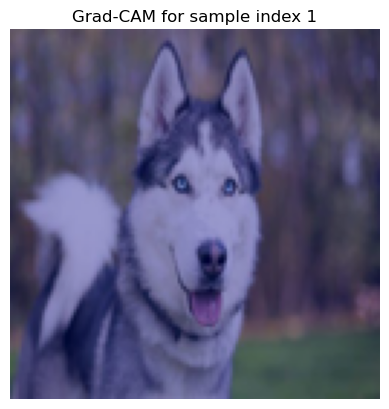

Background focus ratio=0.00. Model is less likely to rely on background.


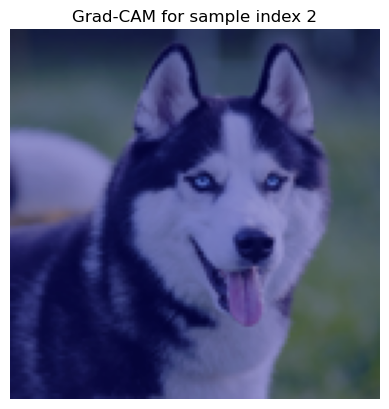

Background focus ratio=0.00. Model is less likely to rely on background.


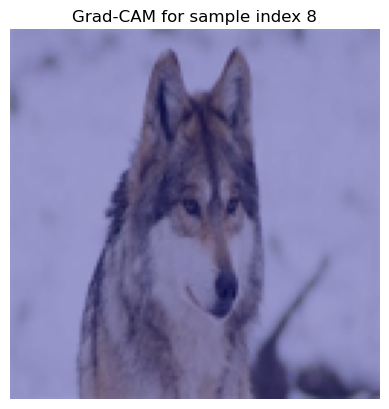

Background focus ratio=0.00. Model is less likely to rely on background.


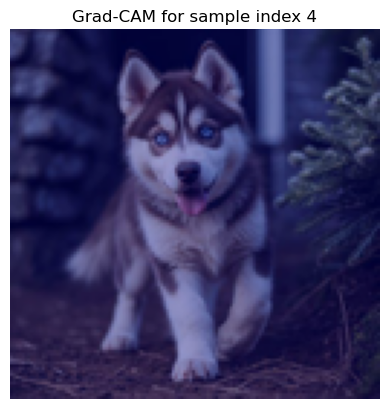

Background focus ratio=0.00. Model is less likely to rely on background.


In [33]:
# Identify the last convolutional layer in the final model.
last_conv_layer_name = None
for layer in final_model.layers[::-1]:
    if isinstance(layer, layers.Conv2D):
        last_conv_layer_name = layer.name
        break
if last_conv_layer_name is None:
    raise ValueError("No convolutional layer found in the model.")

print("Using last conv layer for Grad-CAM:", last_conv_layer_name)

# Grad-CAM on 4 sample test images.
print("Grad-CAM visualization on 4 sample test images:")
sample_indices = np.random.choice(len(X_test), size=4, replace=False)
for idx in sample_indices:
    sample_image = X_test[idx]
    heatmap = get_gradcam_heatmap(final_model, sample_image, last_conv_layer_name)
    plt.figure()
    plt.title(f"Grad-CAM for sample index {idx}")
    display_gradcam(sample_image, heatmap)

    # 2) Check background focus
    heatmap_ratio = check_background_focus(sample_image, heatmap, top_fraction=0.4)
    if heatmap_ratio > 0.5:
        print(f"High background focus (ratio={heatmap_ratio:.2f}). Model might be relying on background leakage.")
    else:
        print(f"Background focus ratio={heatmap_ratio:.2f}. Model is less likely to rely on background.")
